# This Looks Like That There

Main training notebook.

In [1]:
import os
import sys
import time
import imp #imp.reload(module)

import numpy as np
from tqdm import trange
from icecream import ic

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf

import network
import experiment_settings 
import data_functions
import push_prototypes
import plots
import common_functions

In [9]:
__author__ = "Elizabeth A. Barnes and Randal J Barnes"
__version__ = "1 December 2021"

In [10]:
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
dpiFig = 300.

## Print the detailed system info

In [11]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"tensorflow version = {tf.__version__}")

python version = 3.9.12 (main, Apr  5 2022, 01:53:17) 
[Clang 12.0.0 ]
numpy version = 1.21.5
tensorflow version = 2.9.0


## Define experiment settings and directories

In [12]:
EXP_NAME = 'alas_fourteenday_precip'#'balanced_test'#initial_test'#'mjo'#'quadrants_testcase'

imp.reload(experiment_settings)
settings = experiment_settings.get_settings(EXP_NAME)

imp.reload(common_functions)
model_dir, model_diagnostics_dir, vizualization_dir = common_functions.get_exp_directories(EXP_NAME)

## Define the network parameters

In [13]:
RANDOM_SEED          = settings['random_seed']
BATCH_SIZE_PREDICT   = settings['batch_size_predict']
BATCH_SIZE           = settings['batch_size']
NLAYERS              = settings['nlayers']
NFILTERS             = settings['nfilters']   
assert(len(NFILTERS)==NLAYERS)

NCLASSES             = settings['nclasses']
PROTOTYPES_PER_CLASS = settings['prototypes_per_class']
NPROTOTYPES          = np.sum(PROTOTYPES_PER_CLASS)

NEPOCHS              = settings['nepochs']
LR_INIT              = settings['lr']
LR_CALLBACK_EPOCH    = settings['lr_cb_epoch']
PATIENCE             = 100

## Initialize

In [14]:
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## Get and process the data

False
(73000, 64, 209, 1)


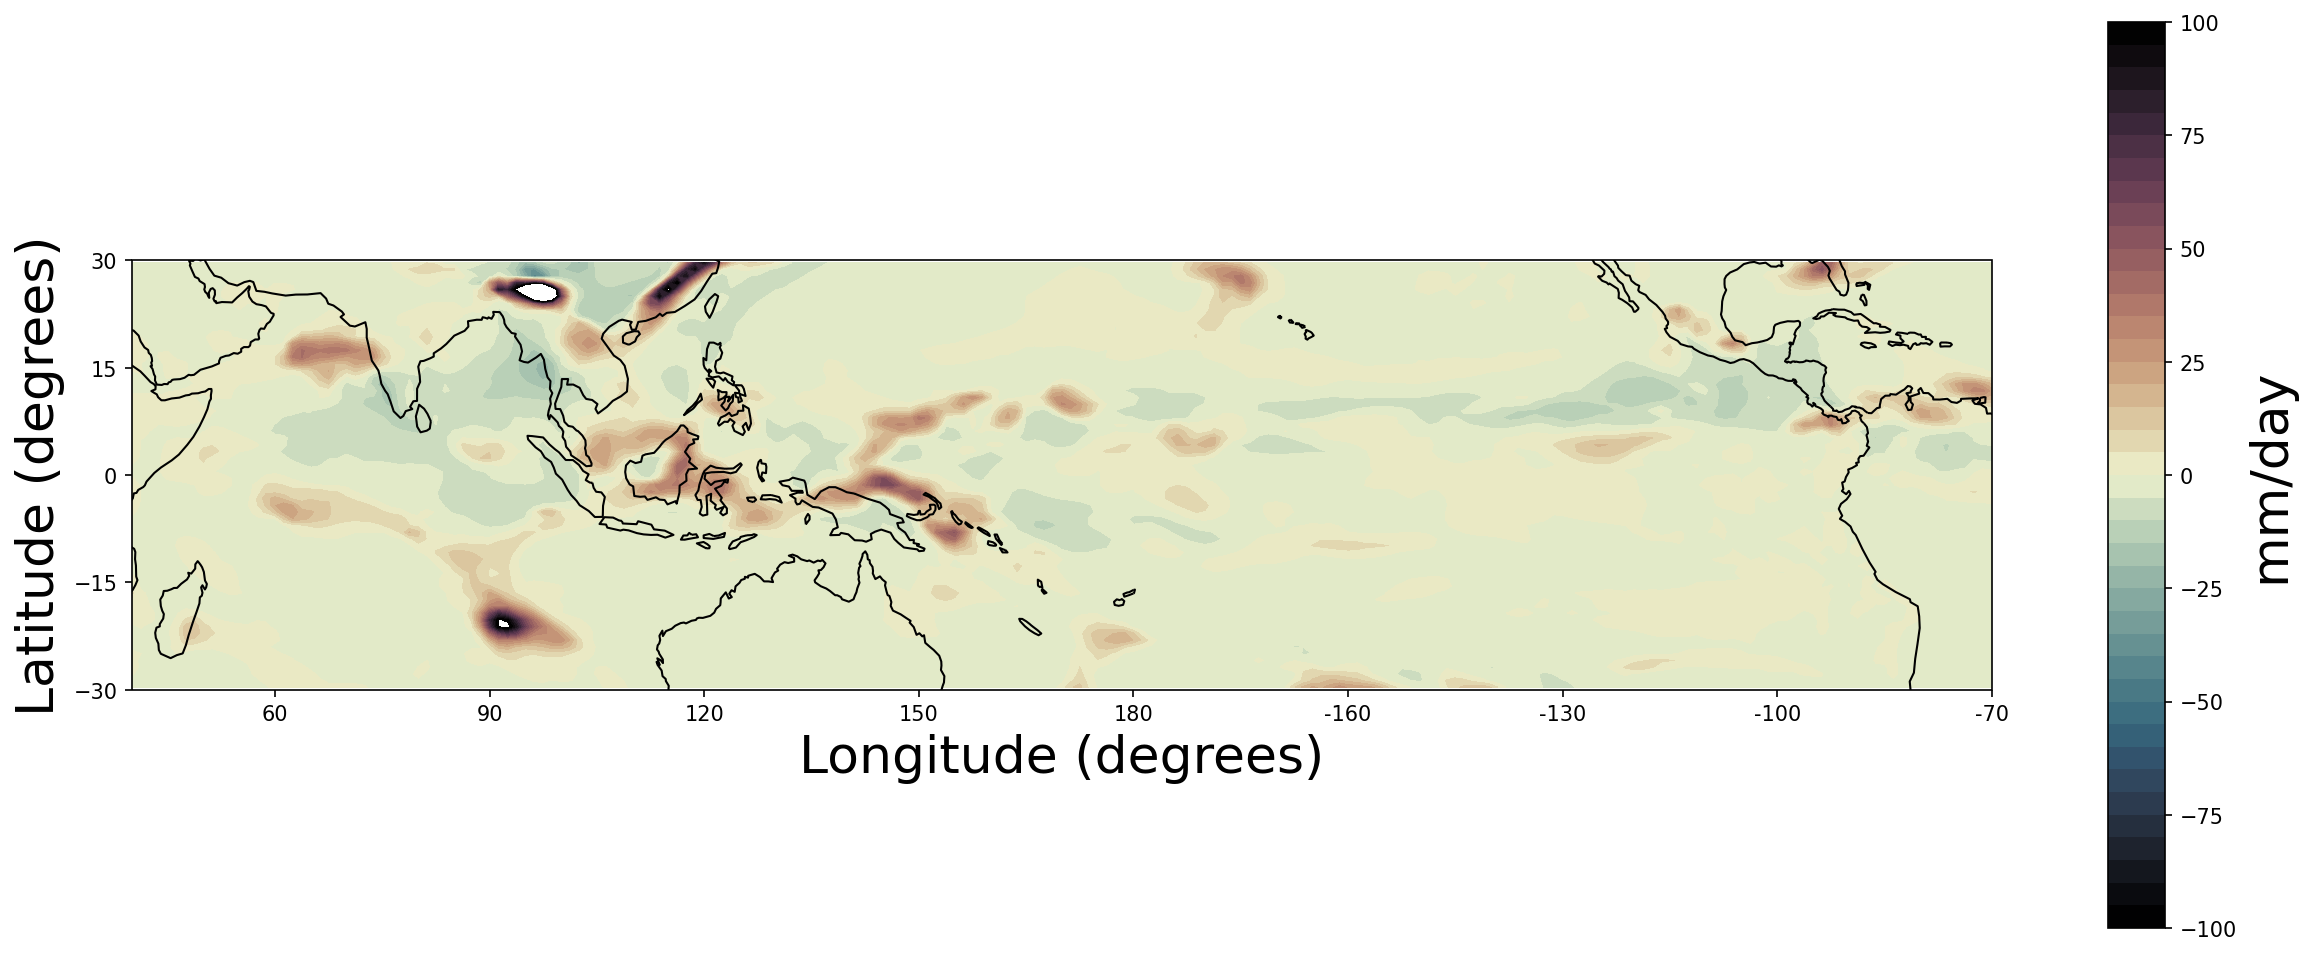

200
Mean: 2.220446049250313e-18


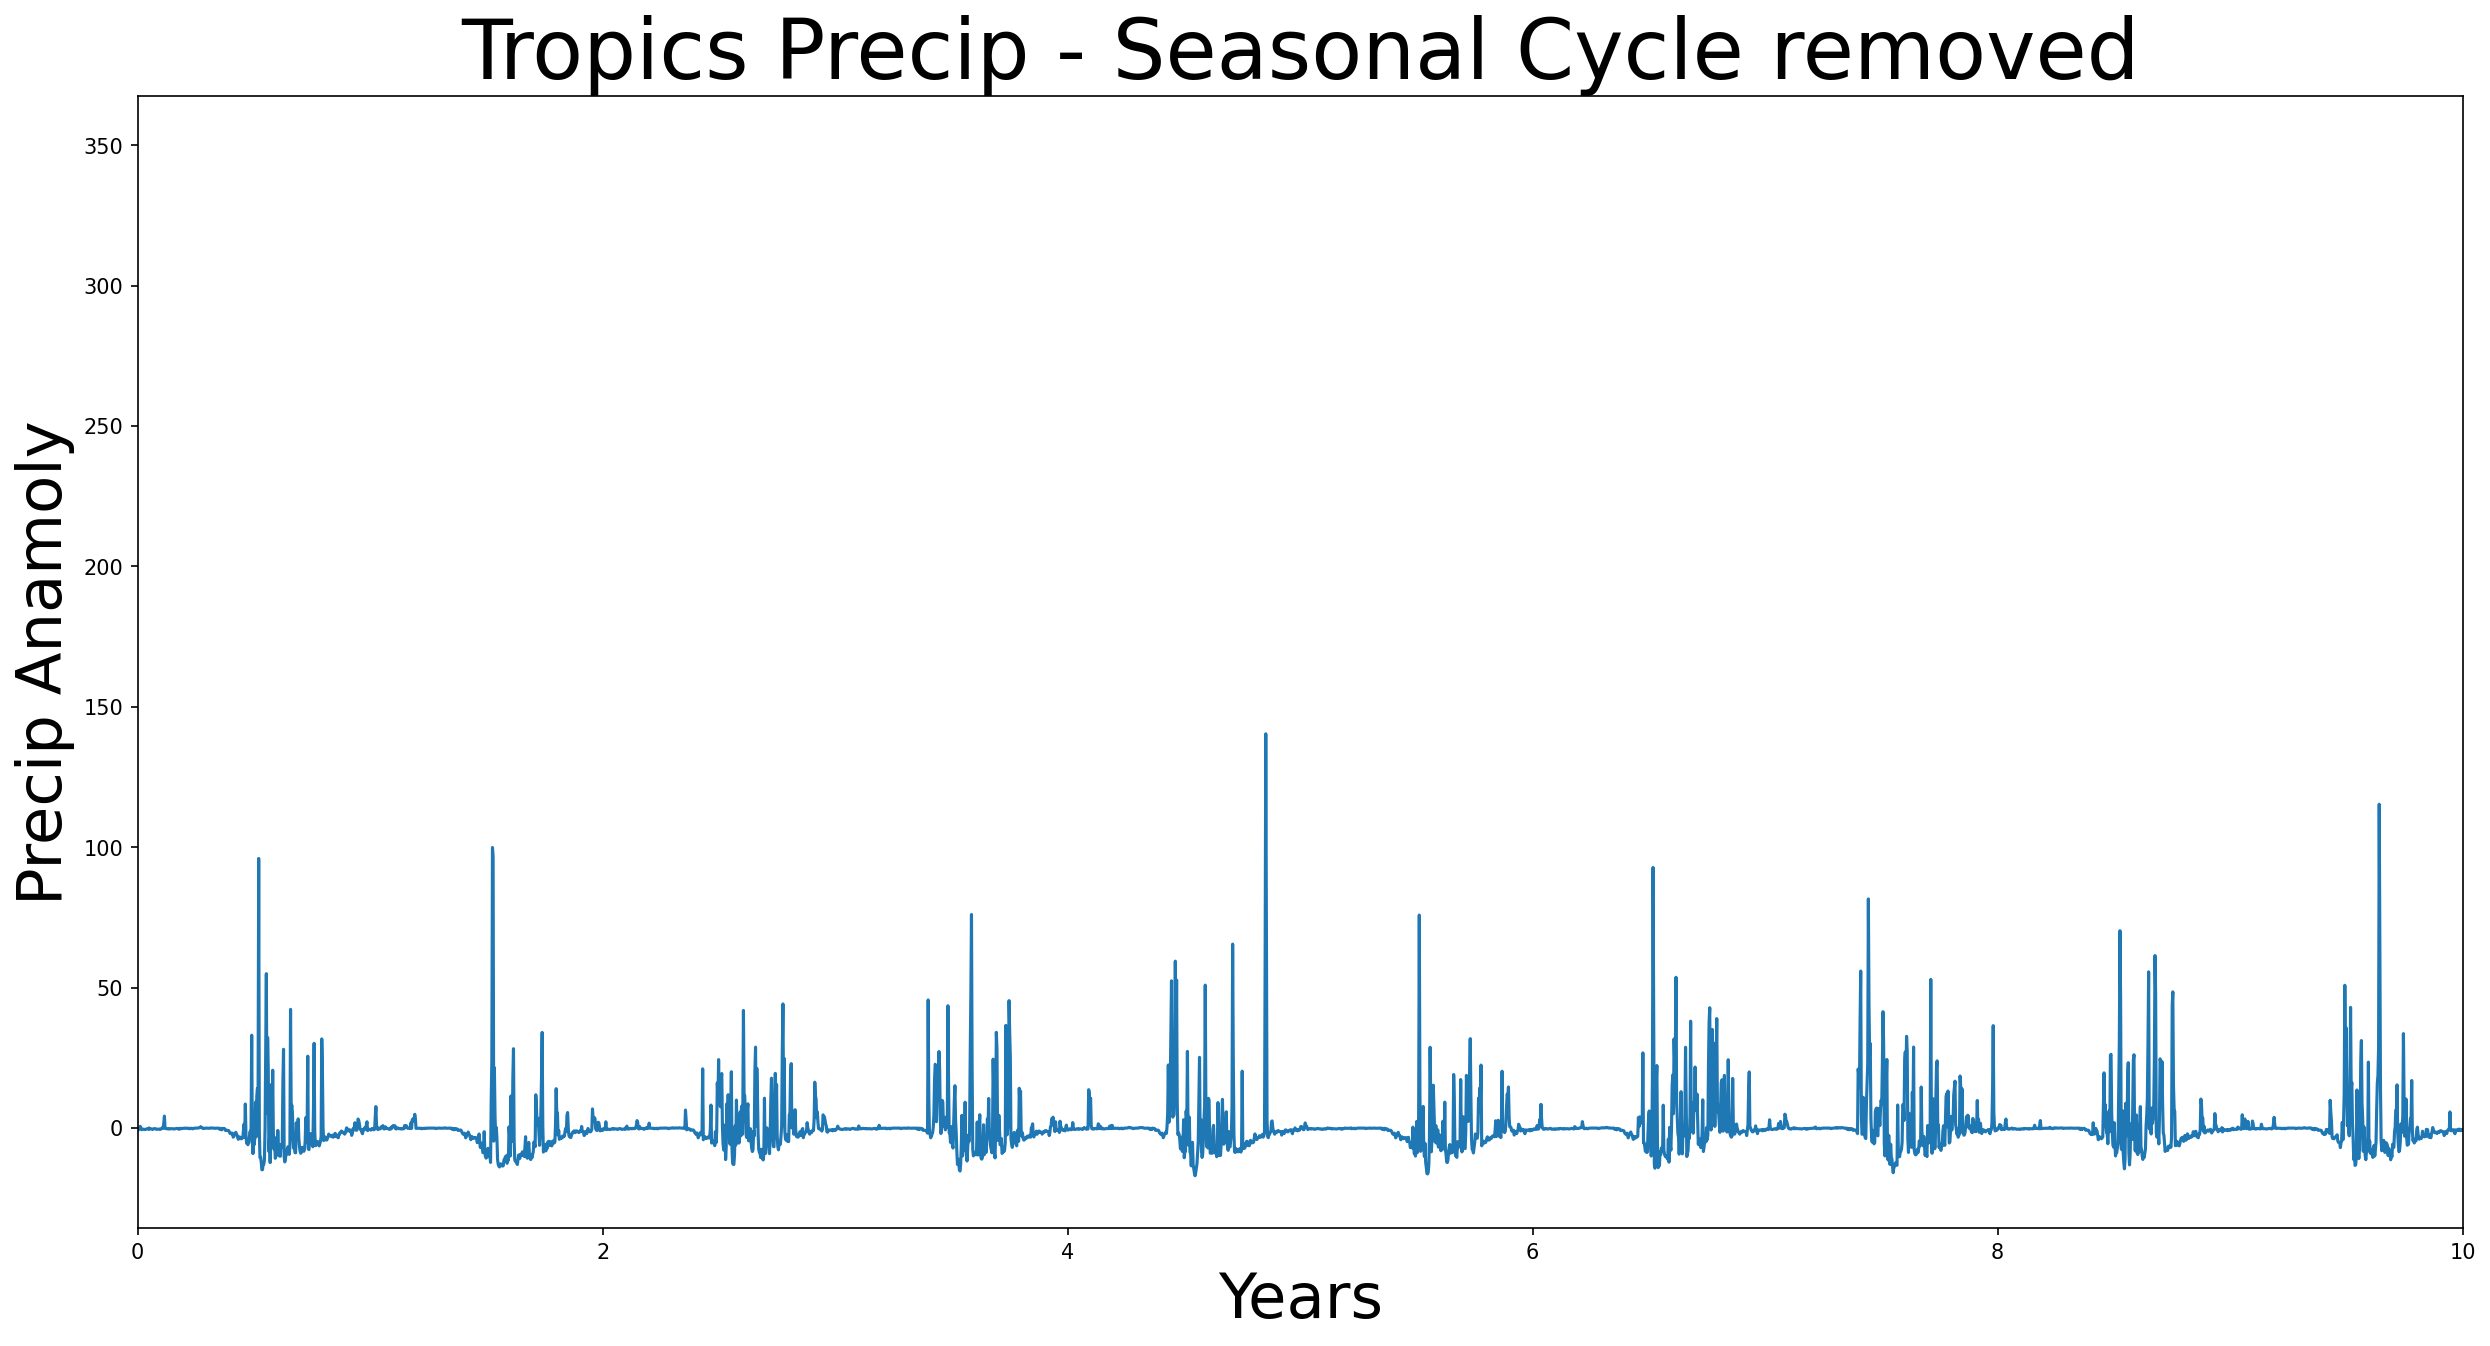

ic| years_train: array([1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810,
                        1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821,
                        1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832,
                        1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843,
                        1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854,
                        1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865,
                        1866, 1867, 1868, 1869])
ic| years_val: array([1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880,
                      1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891,
                      1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902,
                      1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913,
                      1914, 1915, 1916, 1917, 1918, 1919])


raw_data        = (73000, 64, 209, 1)
training data   = (25550, 64, 209, 1), (25550,)
validation data = (18250, 64, 209, 1), (18250,)
test data       = (29200, 64, 209, 1), (29200,)
X_mean          = 0.00026410032138590576
X_std           = 7.313029816445981


In [15]:
imp.reload(data_functions)
DATA_NAME = settings['data_name']
DATA_DIR = settings['data_dir']

# print(data_functions)

# if(EXP_NAME[:3]=='mjo'):

#     labels, data, lat, lon, time = data_functions.load_mjo_data(DATA_DIR)
#     X_train, y_train, time_train, X_val, y_val, time_val, X_test, y_test, time_test = data_functions.get_and_process_mjo_data(labels,
#                                                                                          data,
#                                                                                          time,
#                                                                                          rng, 
#                                                                                          colored=settings['colored'],
#                                                                                          standardize=settings['standardize'],
#                                                                                          shuffle=settings['shuffle'],
#                                                                                         )        
if(EXP_NAME[:9]=='quadrants'):
    filename = DATA_DIR + DATA_NAME + '.mat'
    X_train, y_train, X_val, y_val, X_test, y_test, lat, lon = data_functions.get_and_process_data(filename, 
                                                                                        rng, 
                                                                                        colored=settings['colored'],
                                                                                        standardize=settings['standardize'],
                                                                                        shuffle=settings['shuffle'],
                                                                                        )      
elif((EXP_NAME[:12]=='initial_test') or (EXP_NAME[:12]=='smaller_test') or (EXP_NAME[:13]=='balanced_test') or (EXP_NAME[:13]=='threeday_test') or (EXP_NAME[:12]=='zeroday_test') or (EXP_NAME[:16]=='fourteenday_test') or (EXP_NAME[:18]=='fourteenday_precip')
     or (EXP_NAME[:19]=='seventeenday_precip') or (EXP_NAME[:16]=='elevenday_precip') or (EXP_NAME[:30]=='fixed_fourteenday_precip') or (EXP_NAME[:30]=='cold_fourteenday_precip') or (EXP_NAME[:30]=='mjo_fourteenday_precip') or (EXP_NAME[:30]=='shuffle_fourteenday_precip')
     or (EXP_NAME[:30]=='cali_fourteenday_precip') or (EXP_NAME[:30]=='alas_fourteenday_precip')):
    print(settings['shuffle'])
    labels, data, lat, lon, time = data_functions.load_pres_data(DATA_DIR)
    X_train, y_train, time_train, X_val, y_val, time_val, X_test, y_test, time_test = data_functions.get_and_process_pres_data(labels,
                                                                                         data,
                                                                                         time,
                                                                                         rng, 
                                                                                         colored=settings['colored'],
                                                                                         standardize=settings['standardize'],
                                                                                         shuffle=settings['shuffle'],
                                                                                        )
elif((EXP_NAME[:21]=='fourteenday_both_test') or ((EXP_NAME[:18]=='threeday_both_test'))):
    print("bingo")
    labels, data, lat, lon, time = data_functions.load_z500_precip_data(DATA_DIR)
    X_train, y_train, time_train, X_val, y_val, time_val, X_test, y_test, time_test = data_functions.get_and_process_pres_data(labels,
                                                                                         data,
                                                                                         time,
                                                                                         rng, 
                                                                                         colored=settings['colored'],
                                                                                         standardize=settings['standardize'],
                                                                                         shuffle=settings['shuffle'],
                                                                                        )

In [16]:
proto_class_mask = network.createClassIdentity(PROTOTYPES_PER_CLASS)

prototypes_of_correct_class_train = np.zeros((len(y_train),NPROTOTYPES))
for i in range(0,prototypes_of_correct_class_train.shape[0]):
    prototypes_of_correct_class_train[i,:] = proto_class_mask[:,int(y_train[i])]
    
prototypes_of_correct_class_val   = np.zeros((len(y_val),NPROTOTYPES))    
for i in range(0,prototypes_of_correct_class_val.shape[0]):
    prototypes_of_correct_class_val[i,:] = proto_class_mask[:,int(y_val[i])]

prototypes_of_correct_class_test   = np.zeros((len(y_test),NPROTOTYPES))    
for i in range(0,prototypes_of_correct_class_test.shape[0]):
    prototypes_of_correct_class_test[i,:] = proto_class_mask[:,int(y_test[i])]
    

## Define the training callbacks and metrics

In [17]:
# callbacks
def scheduler(epoch, lr):
    if epoch < LR_CALLBACK_EPOCH:
        return np.round(lr,8)
    else:
        if(epoch % 2 == 0):
            return lr/2.
        else:
            return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)    
    
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_sparse_categorical_accuracy', 
    mode='max',
    patience=settings['patience'], 
    restore_best_weights=True, 
    verbose=1
)

callbacks_list = [
#     lr_callback,
#     es_callback,
]            

# metrics
metrics_list = [
    tf.keras.metrics.SparseCategoricalAccuracy(),
]

2022-10-04 01:19:22.917259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Instantiate the model

In [18]:
__ = imp.reload(network)
tf.keras.backend.clear_session()

model = network.build_model(
    nlayers              = NLAYERS,
    nfilters             = NFILTERS,
    input_shape          = X_train.shape[1:],
    output_shape         = NCLASSES,
    prototypes_per_class = PROTOTYPES_PER_CLASS,
    network_seed         = RANDOM_SEED,    
    prototype_channels   = settings['prototype_channels'],    
    coeff_cluster        = settings['coeff_cluster'],
    coeff_separation     = settings['coeff_separation'],
    coeff_l1             = settings['coeff_l1'],
    incorrect_strength   = settings['incorrect_strength'],
    double_conv          = settings['double_conv'],
    kernel_l1_coeff      = 0.0,#settings['kernel_l1_coeff'],
    kernel_l2_coeff      = 0.0,#settings['kernel_l2_coeff'],
    drop_rate            = 0.0,
    drop_rate_final      = 0.0,        
    
)
model.summary()

3
[16, 16, 16]
(64, 209, 1)
3
[10, 10, 10]
30
False
0.2
-0.02
0.1
-0.5
False
8
64
0.0
0.0
0.0
0.0
False
Model: "full_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 64, 209, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv_0 (Conv2D)                (None, 64, 209, 16)  160         ['inputs[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 64, 209, 16)  0           ['conv_0[0][0]']                 
                                                                                    

## Load pre-trained weights into convolutional layers

In [19]:
if(settings['pretrain'] == True):

    if(settings['pretrain_exp'] is None):
        PRETRAINED_MODEL = model_dir + 'pretrained_model_' + EXP_NAME 
    else:
        PRETRAINED_MODEL = './saved_models/' + settings['pretrain_exp'] 

    print('loading pretrained convolutional layers from ' + PRETRAINED_MODEL)
    pretrained_model = tf.keras.models.load_model(PRETRAINED_MODEL)

    for layer in range(1,len(model.layers)):
        if(model.layers[layer].name[:4]=='conv'):
            print('   loading pretrained weights for --> ' + model.layers[layer].name)
            model.layers[layer].set_weights(pretrained_model.layers[layer].get_weights())
else:
    print('no pretrained model specified. keeping random initialized weights.')
    

no pretrained model specified. keeping random initialized weights.


In [20]:
# raise ValueError('here')

***

# Run Training Stages

In [21]:
imp.reload(network)
imp.reload(plots)
imp.reload(push_prototypes)
imp.reload(experiment_settings)
settings = experiment_settings.get_settings(EXP_NAME)

In [22]:
ic(np.shape(X_train))
ic(np.shape(prototypes_of_correct_class_train))
ic(np.shape(prototypes_of_correct_class_train))

ic| np.shape(X_train): (25550, 64, 209, 1)
ic| np.shape(prototypes_of_correct_class_train): (25550, 30)
ic| np.shape(prototypes_of_correct_class_train): (25550, 30)


(25550, 30)

In [23]:
imp.reload(push_prototypes)
NEPOCHS    = settings['nepochs']
STAGE_LIST = (0,1,2,3,4,5,6,7,8,9)#range(len(NEPOCHS))#(1,2,3,4,5)#range(len(NEPOCHS))

for stage in STAGE_LIST:
    
    print('--------------------')
    print('TRAINING STAGE = ' + str(stage))
    print('--------------------')

    # load previously trained stage, unless it is the 0th stage
    if(stage != 0):
        tf.keras.backend.clear_session()
        model_filename = model_dir + 'model_' + EXP_NAME + '_stage' + str(stage-1)
#         model = common_functions.load_model(model_filename)
        model.load_weights(model_filename)
        
    # learn layers (during even numbered stages)
    if(stage % 2 == 0):
        # train prototypes layers (and possibly CNN layers)
        if(settings['pretrain']==False and settings['train_cnn_in_stage'] == True):
            model = network.set_trainable_layers(model, [True,True,True,False])            
        elif(settings['train_cnn_in_stage'] == False or stage==0):
            model = network.set_trainable_layers(model, [False,True,True,False])
        elif(settings['train_cnn_in_stage'] == True):
            model = network.set_trainable_layers(model, [True,True,True,False])            
        elif(stage >= settings['train_cnn_in_stage']):
            model = network.set_trainable_layers(model, [True,True,True,False])            
        else:
            model = network.set_trainable_layers(model, [False,True,True,False])
    else:
        #.......................................................
        # push the prototypes
        #.......................................................        
        model, push_info = push_prototypes.push(model, 
                                                [X_train,prototypes_of_correct_class_train], 
                                                prototypes_of_correct_class_train, 
                                                perform_push=True,
                                                batch_size=BATCH_SIZE_PREDICT,
                                                verbose=False,
                                               )        
        print('Push complete.\n')            

        # train weights layer only
        model = network.set_trainable_layers(model, [False,False,False,True])        

    #.......................................................
    # compile the model
    #.......................................................
    if(stage>=settings['cut_lr_stage']):
        lr_factor = 10.**(np.floor((stage-settings['cut_lr_stage']+2)/2))
    else:
        lr_factor = 1.
    if(LR_INIT/lr_factor<settings['min_lr']):
        lr_factor = LR_INIT/settings['min_lr']
    print('learning rate = ' + str(np.asarray(LR_INIT/lr_factor,dtype='float32')))

    # compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=np.asarray(LR_INIT/lr_factor,dtype='float32'), 
        ),
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics = metrics_list,
    )
#     model.summary()
    ic(np.min(model.layers[-3].get_weights()[1]),np.max(model.layers[-3].get_weights()[1]))

    #.......................................................
    # train the model
    #.......................................................
    print('Training the model...')    
    
    tf.random.set_seed(RANDOM_SEED)   
    np.random.seed(RANDOM_SEED)    
    history = model.fit(
        [X_train,prototypes_of_correct_class_train],
        y_train,
        validation_data=([[X_val,prototypes_of_correct_class_val]], [y_val]),
        batch_size=BATCH_SIZE,
        epochs=NEPOCHS[stage],
        shuffle=True,
        verbose=1,
        callbacks=callbacks_list
    )
    print('Training complete.\n')            
        

    # save the model at this training stage
    model_filename = model_dir + 'model_' + EXP_NAME + '_stage' + str(stage)
    common_functions.save_model(model, model_filename) 
    
    #.......................................................
    # plot results
    #.......................................................  
    try:
        # plot loss history of the model
        plots.plot_loss_history(history)
        plt.savefig(model_diagnostics_dir + EXP_NAME + '_loss_history_stage' + str(stage) + '.png', dpi=dpiFig)    
        plt.close()

        # plot the weights
        plots.plot_weights(model, PROTOTYPES_PER_CLASS)    
        plt.savefig(model_diagnostics_dir + EXP_NAME + '_weights_stage' + str(stage) + '.png', dpi=dpiFig)
        plt.close()
    except:
        print('not making plots...')
        plt.close()

ic| np.min(model.layers[-3].get_weights()[1]): 0.0
    np.max(model.layers[-3].get_weights()[1]): 0.0


--------------------
TRAINING STAGE = 0
--------------------
   conv_0 --> True
   maxpooling_0 --> True
   conv_1 --> True
   maxpooling_1 --> True
   conv_2 --> True
   maxpooling_2 --> True
   first_1x1_conv --> True
   second_1x1_conv --> True
   prototype --> True
   final_weights --> False
learning rate = 0.01
Training the model...
Epoch 1/10
799/799 [==============================] - 82s 101ms/step - loss: 4.2267 - sparse_categorical_accuracy: 0.3384 - cluster_cost: 0.5277 - separation_cost: 0.4557 - l1_weights_cost: 3.0000 - val_loss: 4.2067 - val_sparse_categorical_accuracy: 0.3361 - val_cluster_cost: 0.2574 - val_separation_cost: 0.2316 - val_l1_weights_cost: 3.0000
Epoch 2/10
799/799 [==============================] - 76s 95ms/step - loss: 4.1669 - sparse_categorical_accuracy: 0.3428 - cluster_cost: 0.2349 - separation_cost: 0.2144 - l1_weights_cost: 3.0000 - val_loss: 4.1886 - val_sparse_categorical_accuracy: 0.3359 - val_cluster_cost: 0.2057 - val_separation_cost: 0.1836 -

INFO:tensorflow:Assets written to: ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage0/assets


INFO:tensorflow:Assets written to: ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage0/assets


--------------------
TRAINING STAGE = 1
--------------------
Running Prototype Push


2022-10-04 01:31:59.932028: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage0: FAILED_PRECONDITION: saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage0; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


9/9 [==============================] - 3s 367ms/step
Performing push of prototypes.
Push complete.

   conv_0 --> False
   maxpooling_0 --> False
   conv_1 --> False
   maxpooling_1 --> False
   conv_2 --> False
   maxpooling_2 --> False
   first_1x1_conv --> False
   second_1x1_conv --> False
   prototype --> False
   final_weights --> True
learning rate = 0.01


ic| np.min(model.layers[-3].get_weights()[1]): -0.9039621
    np.max(model.layers[-3].get_weights()[1]): 2.8271782


Training the model...
Epoch 1/10
799/799 [==============================] - 36s 44ms/step - loss: 6.4455 - sparse_categorical_accuracy: 0.3607 - cluster_cost: 1.4189e-05 - separation_cost: 1.9097e-08 - l1_weights_cost: 0.6870 - val_loss: 1.6915 - val_sparse_categorical_accuracy: 0.3455 - val_cluster_cost: 1.3762e-05 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.1508
Epoch 2/10
799/799 [==============================] - 28s 35ms/step - loss: 1.3052 - sparse_categorical_accuracy: 0.3534 - cluster_cost: 1.4238e-05 - separation_cost: 1.9097e-08 - l1_weights_cost: 0.0664 - val_loss: 1.4265 - val_sparse_categorical_accuracy: 0.3344 - val_cluster_cost: 1.3762e-05 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.0219
Epoch 3/10
799/799 [==============================] - 28s 35ms/step - loss: 1.2524 - sparse_categorical_accuracy: 0.3494 - cluster_cost: 1.4189e-05 - separation_cost: 1.9097e-08 - l1_weights_cost: 0.0185 - val_loss: 1.1937 - val_sparse_categorical_accuracy: 

INFO:tensorflow:Assets written to: ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage1/assets


INFO:tensorflow:Assets written to: ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage1/assets
2022-10-04 01:37:22.872176: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage1: FAILED_PRECONDITION: saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage1; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
ic| np.min(model.layers[-3].get_weights()[1]): -0.9039621
    np.max(model.layers[-3].get_weights()[1]): 2.8271782


--------------------
TRAINING STAGE = 2
--------------------
   conv_0 --> True
   maxpooling_0 --> True
   conv_1 --> True
   maxpooling_1 --> True
   conv_2 --> True
   maxpooling_2 --> True
   first_1x1_conv --> True
   second_1x1_conv --> True
   prototype --> True
   final_weights --> False
learning rate = 0.01
Training the model...
Epoch 1/10
799/799 [==============================] - 80s 100ms/step - loss: 1.1123 - sparse_categorical_accuracy: 0.3653 - cluster_cost: 0.0135 - separation_cost: 0.0066 - l1_weights_cost: 0.0158 - val_loss: 1.1169 - val_sparse_categorical_accuracy: 0.3531 - val_cluster_cost: 0.0216 - val_separation_cost: 0.0089 - val_l1_weights_cost: 0.0158
Epoch 2/10
799/799 [==============================] - 73s 91ms/step - loss: 1.1053 - sparse_categorical_accuracy: 0.3786 - cluster_cost: 0.0126 - separation_cost: 0.0064 - l1_weights_cost: 0.0158 - val_loss: 1.1123 - val_sparse_categorical_accuracy: 0.3649 - val_cluster_cost: 0.0176 - val_separation_cost: 0.0092 -

INFO:tensorflow:Assets written to: ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage2/assets


INFO:tensorflow:Assets written to: ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage2/assets


--------------------
TRAINING STAGE = 3
--------------------
Running Prototype Push


2022-10-04 01:49:47.363322: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage2: FAILED_PRECONDITION: saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage2; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


9/9 [==============================] - 4s 376ms/step
Performing push of prototypes.
Push complete.

   conv_0 --> False
   maxpooling_0 --> False
   conv_1 --> False
   maxpooling_1 --> False
   conv_2 --> False
   maxpooling_2 --> False
   first_1x1_conv --> False
   second_1x1_conv --> False
   prototype --> False
   final_weights --> True
learning rate = 0.01


ic| np.min(model.layers[-3].get_weights()[1]): -1.7092389
    np.max(model.layers[-3].get_weights()[1]): 4.674522


Training the model...
Epoch 1/10
799/799 [==============================] - 36s 44ms/step - loss: 2.4592 - sparse_categorical_accuracy: 0.3548 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0809 - val_loss: 3.2676 - val_sparse_categorical_accuracy: 0.3212 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.0741
Epoch 2/10
799/799 [==============================] - 28s 35ms/step - loss: 2.4121 - sparse_categorical_accuracy: 0.3499 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0574 - val_loss: 2.6538 - val_sparse_categorical_accuracy: 0.3464 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.0484
Epoch 3/10
799/799 [==============================] - 28s 34ms/step - loss: 2.1244 - sparse_categorical_accuracy: 0.3507 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0439 - val_loss: 2.0533 - val_sparse_categorical_accuracy: 

INFO:tensorflow:Assets written to: ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage3/assets


INFO:tensorflow:Assets written to: ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage3/assets
2022-10-04 01:55:03.875483: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage3: FAILED_PRECONDITION: saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage3; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
ic| np.min(model.layers[-3].get_weights()[1]): -1.7092389
    np.max(model.layers[-3].get_weights()[1]): 4.674522


--------------------
TRAINING STAGE = 4
--------------------
   conv_0 --> True
   maxpooling_0 --> True
   conv_1 --> True
   maxpooling_1 --> True
   conv_2 --> True
   maxpooling_2 --> True
   first_1x1_conv --> True
   second_1x1_conv --> True
   prototype --> True
   final_weights --> False
learning rate = 0.001
Training the model...
Epoch 1/10
799/799 [==============================] - 79s 97ms/step - loss: 1.1885 - sparse_categorical_accuracy: 0.3626 - cluster_cost: 0.0064 - separation_cost: 0.0047 - l1_weights_cost: 0.0283 - val_loss: 1.1416 - val_sparse_categorical_accuracy: 0.3547 - val_cluster_cost: 0.0120 - val_separation_cost: 0.0091 - val_l1_weights_cost: 0.0283
Epoch 2/10
799/799 [==============================] - 72s 90ms/step - loss: 1.1222 - sparse_categorical_accuracy: 0.3826 - cluster_cost: 0.0134 - separation_cost: 0.0103 - l1_weights_cost: 0.0283 - val_loss: 1.1323 - val_sparse_categorical_accuracy: 0.3552 - val_cluster_cost: 0.0147 - val_separation_cost: 0.0116 -

INFO:tensorflow:Assets written to: ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage4/assets


INFO:tensorflow:Assets written to: ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage4/assets


--------------------
TRAINING STAGE = 5
--------------------
Running Prototype Push


2022-10-04 02:07:19.480387: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage4: FAILED_PRECONDITION: saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage4; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


9/9 [==============================] - 4s 365ms/step
Performing push of prototypes.
Push complete.

   conv_0 --> False
   maxpooling_0 --> False
   conv_1 --> False
   maxpooling_1 --> False
   conv_2 --> False
   maxpooling_2 --> False
   first_1x1_conv --> False
   second_1x1_conv --> False
   prototype --> False
   final_weights --> True
learning rate = 0.001


ic| np.min(model.layers[-3].get_weights()[1]): -1.8017144
    np.max(model.layers[-3].get_weights()[1]): 4.127186


Training the model...
Epoch 1/10
799/799 [==============================] - 38s 47ms/step - loss: 1.1626 - sparse_categorical_accuracy: 0.3711 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0076 - val_loss: 1.1396 - val_sparse_categorical_accuracy: 0.3548 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.0053
Epoch 2/10
799/799 [==============================] - 28s 35ms/step - loss: 1.1539 - sparse_categorical_accuracy: 0.3718 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0061 - val_loss: 1.2679 - val_sparse_categorical_accuracy: 0.3415 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.0075
Epoch 3/10
799/799 [==============================] - 28s 35ms/step - loss: 1.1581 - sparse_categorical_accuracy: 0.3755 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0064 - val_loss: 1.1258 - val_sparse_categorical_accuracy: 

INFO:tensorflow:Assets written to: ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage5/assets


INFO:tensorflow:Assets written to: ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage5/assets
2022-10-04 02:12:33.205277: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage5: FAILED_PRECONDITION: saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage5; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
ic| np.min(model.layers[-3].get_weights()[1]): -1.8017144
    np.max(model.layers[-3].get_weights()[1]): 4.127186


--------------------
TRAINING STAGE = 6
--------------------
   conv_0 --> True
   maxpooling_0 --> True
   conv_1 --> True
   maxpooling_1 --> True
   conv_2 --> True
   maxpooling_2 --> True
   first_1x1_conv --> True
   second_1x1_conv --> True
   prototype --> True
   final_weights --> False
learning rate = 1e-04
Training the model...
Epoch 1/10
799/799 [==============================] - 82s 101ms/step - loss: 1.0881 - sparse_categorical_accuracy: 0.3832 - cluster_cost: 3.3377e-05 - separation_cost: 5.5737e-06 - l1_weights_cost: 0.0069 - val_loss: 1.1073 - val_sparse_categorical_accuracy: 0.3653 - val_cluster_cost: 2.2966e-04 - val_separation_cost: 8.0837e-05 - val_l1_weights_cost: 0.0069
Epoch 2/10
799/799 [==============================] - 73s 92ms/step - loss: 1.0846 - sparse_categorical_accuracy: 0.4025 - cluster_cost: 4.3954e-04 - separation_cost: 3.8309e-04 - l1_weights_cost: 0.0069 - val_loss: 1.1047 - val_sparse_categorical_accuracy: 0.3671 - val_cluster_cost: 4.8324e-04 - 

INFO:tensorflow:Assets written to: ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage6/assets


INFO:tensorflow:Assets written to: ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage6/assets


--------------------
TRAINING STAGE = 7
--------------------
Running Prototype Push


2022-10-04 02:24:54.872548: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage6: FAILED_PRECONDITION: saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage6; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


9/9 [==============================] - 4s 375ms/step
Performing push of prototypes.
Push complete.

   conv_0 --> False
   maxpooling_0 --> False
   conv_1 --> False
   maxpooling_1 --> False
   conv_2 --> False
   maxpooling_2 --> False
   first_1x1_conv --> False
   second_1x1_conv --> False
   prototype --> False
   final_weights --> True
learning rate = 1e-04


ic| np.min(model.layers[-3].get_weights()[1]): -1.8642186
    np.max(model.layers[-3].get_weights()[1]): 4.0487103


Training the model...
Epoch 1/10
799/799 [==============================] - 36s 44ms/step - loss: 1.0831 - sparse_categorical_accuracy: 0.3869 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0032 - val_loss: 1.1104 - val_sparse_categorical_accuracy: 0.3596 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.0027
Epoch 2/10
799/799 [==============================] - 28s 35ms/step - loss: 1.0810 - sparse_categorical_accuracy: 0.4021 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0024 - val_loss: 1.1032 - val_sparse_categorical_accuracy: 0.3660 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.0029
Epoch 3/10
799/799 [==============================] - 28s 35ms/step - loss: 1.0821 - sparse_categorical_accuracy: 0.4018 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0025 - val_loss: 1.1298 - val_sparse_categorical_accuracy: 

INFO:tensorflow:Assets written to: ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage7/assets


INFO:tensorflow:Assets written to: ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage7/assets
2022-10-04 02:30:12.949172: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage7: FAILED_PRECONDITION: saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage7; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
ic| np.min(model.layers[-3].get_weights()[1]): -1.8642186
    np.max(model.layers[-3].get_weights()[1]): 4.0487103


--------------------
TRAINING STAGE = 8
--------------------
   conv_0 --> True
   maxpooling_0 --> True
   conv_1 --> True
   maxpooling_1 --> True
   conv_2 --> True
   maxpooling_2 --> True
   first_1x1_conv --> True
   second_1x1_conv --> True
   prototype --> True
   final_weights --> False
learning rate = 1e-05
Training the model...
Epoch 1/10
799/799 [==============================] - 83s 102ms/step - loss: 1.0798 - sparse_categorical_accuracy: 0.3816 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0024 - val_loss: 1.1051 - val_sparse_categorical_accuracy: 0.3614 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.0024
Epoch 2/10
799/799 [==============================] - 73s 91ms/step - loss: 1.0775 - sparse_categorical_accuracy: 0.3992 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0024 - val_loss: 1.1029 - val_sparse_categorical_accuracy: 0.3633 - val_cluster_cost: 0.0000e+00 - 

INFO:tensorflow:Assets written to: ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage8/assets


INFO:tensorflow:Assets written to: ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage8/assets


--------------------
TRAINING STAGE = 9
--------------------
Running Prototype Push


2022-10-04 02:42:33.047999: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage8: FAILED_PRECONDITION: saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage8; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


9/9 [==============================] - 4s 370ms/step
Performing push of prototypes.
Push complete.

   conv_0 --> False
   maxpooling_0 --> False
   conv_1 --> False
   maxpooling_1 --> False
   conv_2 --> False
   maxpooling_2 --> False
   first_1x1_conv --> False
   second_1x1_conv --> False
   prototype --> False
   final_weights --> True
learning rate = 1e-05


ic| np.min(model.layers[-3].get_weights()[1]): -1.8721862
    np.max(model.layers[-3].get_weights()[1]): 4.0514154


Training the model...
Epoch 1/10
799/799 [==============================] - 40s 47ms/step - loss: 1.0747 - sparse_categorical_accuracy: 0.3914 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0018 - val_loss: 1.0988 - val_sparse_categorical_accuracy: 0.3676 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.0017
Epoch 2/10
799/799 [==============================] - 28s 36ms/step - loss: 1.0735 - sparse_categorical_accuracy: 0.4114 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0016 - val_loss: 1.0975 - val_sparse_categorical_accuracy: 0.3688 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.0016
Epoch 3/10
799/799 [==============================] - 27s 34ms/step - loss: 1.0736 - sparse_categorical_accuracy: 0.4115 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0016 - val_loss: 1.0989 - val_sparse_categorical_accuracy: 

INFO:tensorflow:Assets written to: ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage9/assets


INFO:tensorflow:Assets written to: ./saved_models/cali_fourteenday_precip/model_cali_fourteenday_precip_stage9/assets


In [21]:
"

SyntaxError: EOL while scanning string literal (1845220801.py, line 1)

In [ ]:
"test""test""test""test""test"